In [ ]:

!pip install tensorflow
!pip install tensorflow-text


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 64.6 MB/s eta 0:00:00


In [ ]:
pip install emoji

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.9/240.9 kB 10.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for emoji: filename=emoji-2.2.0-py3-none-any.whl size=234926 sha256=e165ee93e11767b7bb54f8d31a8a3dd32c73db3faf460f7f95f73b55953517f8
  Stored in directory: /root/.cache/pip/wheels/02/3d/88/51a592b9ad17e7899126563698b4e3961983ebe85747228ba6
Successfully built emoji


In [ ]:
pip install contractions

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import pandas as pd
import re
import string
import nltk
import matplotlib.pyplot as plt
import plotly.express as px
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import emoji
import contractions
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text
import gensim
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.layers import Flatten
from sklearn.metrics import classification_report
from keras.layers import SpatialDropout1D
from keras.callbacks import EarlyStopping

## for deep learning
from tensorflow.keras import models, layers, preprocessing as kprocessing
from tensorflow.keras import backend as K

In [ ]:
# Load the dataset
train_data = pd.read_csv('/content/sample_data/categorized_new_tweets.csv')
test_data= pd.read_csv('/content/sample_data/Unseen 5pillarsEarthUK.csv',encoding='cp1252', quotechar='"', delimiter=',')

In [ ]:
# Count the number of tweets in each category
category_counts = train_data['category_name'].value_counts()

# Create a bar plot using plotly
fig = px.bar(category_counts, x=category_counts.index, y=category_counts.values,
             labels={'x': 'Category Names', 'y': 'Number of Tweets'},
             title='Number of Tweets in Each Category',
             width=400, height=600)
# Show the plot
fig.show()

In [ ]:
# download stopwords and lemmatizer
nltk.download('stopwords')
nltk.download('wordnet')

# get stop words
stop_words = set(stopwords.words('english'))
# create lemmatizer
lemmatizer = WordNetLemmatizer()


# define regular expression patterns for removing URLs, HTML tags, and emojis
#url_pattern = re.compile(r'http\S+|www\S+')
#html_pattern = re.compile('<.*?>')
#emoji_pattern = re.compile('[\U0001f600-\U0001f650]')

# define patterns for url, html tags, and emojis
url_pattern = re.compile(r'https?://\S+|www\.\S+')
html_pattern = re.compile(r'<.*?>')
emoji_pattern = re.compile(r'[\U0001F600-\U0001F64F\U0001F300-\U0001F5FF\U0001F680-\U0001F6FF\U0001F1E0-\U0001F1FF]+')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
contractions = {
    "ain't": "am not",
    "aren't": "are not",
    "can't": "cannot",
    "can't've": "cannot have",
    "'cause": "because",
    "could've": "could have",
    "couldn't": "could not",
    "couldn't've": "could not have",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not",
    "hadn't": "had not",
    "hadn't've": "had not have",
    "hasn't": "has not",
    "haven't": "have not",
    "he'd": "he would",
    "he'd've": "he would have",
    "he'll": "he will",
    "he'll've": "he will have",
    "he's": "he is",
    "how'd": "how did",
    "how'd'y": "how do you",
    "how'll": "how will",
    "how's": "how is",
    "I'd": "I would",
    "I'd've": "I would have",
    "I'll": "I will",
    "I'll've": "I will have",
    "I'm": "I am",
    "I've": "I have",
    "isn't": "is not",
    "it'd": "it would",
    "it'd've": "it would have",
    "it'll": "it will",
    "it'll've": "it will have",
    "it's": "it is",
    "let's": "let us",
    "ma'am": "madam",
    "mayn't": "may not",
    "might've": "might have",
    "mightn't": "might not",
    "mightn't've": "might not have",
    "must've": "must have",
    "mustn't": "must not",
    "mustn't've": "must not have",
    "needn't": "need not",
    "needn't've": "need not have",
    "o'clock": "of the clock",
    "oughtn't": "ought not",
    "oughtn't've": "ought not have",
    "shan't": "shall not",
    "sha'n't": "shall not",
    "shan't've": "shall not have",
    "she'd": "she would",
    "she'd've": "she would have",
    "she'll": "she will",
    "she'll've": "she will have",
    "she's": "she is",
    "should've": "should have",
    "shouldn't": "should not",
    "shouldn't've": "should not have",
    "so've": "so have",
    "so's": "so is",
    "that'd": "that would",
    "that'd've": "that would have",
    "that's": "that is",
    "there'd": "there would",
    "there'd've": "they would have"
}

In [ ]:
# function to clean text and lemmatize text
def clean_tokenize_lemmatize(text):
    if isinstance(text, dict):
        text = text['full_text']
    # remove URLs
    text = re.sub(r'http\S+', '', text)
    
    # remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    
    # remove emojis using regex
    text = re.sub(r'[^\w\s,]', '', text)
    
    # remove digits
    text = re.sub(r'\d+', '', text)
    
    # expand contractions
    text = contractions.fix(text)
    
    # convert text to lowercase
    text = text.lower()
    
    # tokenize the text
    tokens = word_tokenize(text)
    
    # remove stop words and lemmatize
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    
    return tokens

In [ ]:
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')

# apply clean_text function to train data
train_data['text'] = train_data['full_text'].apply(clean_tokenize_lemmatize)

# apply clean_text function to test data
test_data['text'] = test_data['full_text'].apply(clean_tokenize_lemmatize)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
# Define the parameters for the tokenizer and the Word2Vec model
vocab_size = 50000
embedding_dim = 512
max_len = 100
window_size = 5
min_count = 1

In [ ]:
# Train the Word2Vec model
data= [row.split(',') for row in (train_data['text'].astype(str))]
word_model = gensim.models.word2vec.Word2Vec(data, vector_size=embedding_dim, window=window_size, min_count=min_count, workers=4)


In [ ]:
# Tokenize the text data
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(train_data['text'])
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))


Found 18946 unique tokens.


In [ ]:
# Convert the text data to sequences of integers
X = tokenizer.texts_to_sequences(train_data['text'])

In [ ]:
# Pad the sequences to have the same length
X = pad_sequences(X, maxlen=max_len)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (13026, 100)


In [ ]:
Y = pd.get_dummies(train_data['category_name']).values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (13026, 4)


In [ ]:
# Split the data into train and test sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state=42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(11723, 100) (11723, 4)
(1303, 100) (1303, 4)


In [ ]:
from keras.layers import Dense, LSTM, Embedding, Dropout, Bidirectional
from keras.models import Sequential
from keras.optimizers import RMSprop

model = Sequential()
model.add(Embedding(input_dim=len(word_model.wv.key_to_index), output_dim=embedding_dim, weights=[word_model.wv.vectors]))
model.add(SpatialDropout1D(0.5))
model.add(Bidirectional(LSTM(units=256)))
model.add(Dropout(0.5))
model.add(Dense(units=4, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer=RMSprop(lr=0.001), metrics=['accuracy'])


/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/rmsprop.py:143: UserWarning:

The `lr` argument is deprecated, use `learning_rate` instead.



In [ ]:
# Train the model
epochs = 10
batch_size = 64
history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, validation_split=0.3, callbacks=[EarlyStopping(monitor='val_loss', min_delta=0.0001)])


Epoch 1/10
129/129 [==============================] - 209s 2s/step - loss: 1.1902 - accuracy: 0.5097 - val_loss: 1.1007 - val_accuracy: 0.5644
Epoch 2/10
129/129 [==============================] - 209s 2s/step - loss: 1.0038 - accuracy: 0.6159 - val_loss: 0.9321 - val_accuracy: 0.6645
Epoch 3/10
129/129 [==============================] - 204s 2s/step - loss: 0.6483 - accuracy: 0.7697 - val_loss: 0.7241 - val_accuracy: 0.7509
Epoch 4/10
129/129 [==============================] - 201s 2s/step - loss: 0.3994 - accuracy: 0.8569 - val_loss: 0.5750 - val_accuracy: 0.8095
Epoch 5/10
129/129 [==============================] - 200s 2s/step - loss: 0.2416 - accuracy: 0.9186 - val_loss: 0.5681 - val_accuracy: 0.8206
Epoch 6/10
129/129 [==============================] - 201s 2s/step - loss: 0.1459 - accuracy: 0.9521 - val_loss: 0.5493 - val_accuracy: 0.8445
Epoch 7/10
129/129 [==============================] - 201s 2s/step - loss: 0.0879 - accuracy: 0.9742 - val_loss: 0.6222 - val_accuracy: 0.8473

In [ ]:
# Evaluate the model on the test set
accr = model.evaluate(X_test, Y_test)
print('Test set\n  Loss: {:0.3f}\n  Validation Accuracy: {:0.3f}'.format(accr[0], accr[1]))

41/41 [==============================] - 8s 183ms/step - loss: 0.6278 - accuracy: 0.8381
Test set
  Loss: 0.628
  Validation Accuracy: 0.838


In [ ]:
# Generate predictions on the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(Y_test, axis=1)

41/41 [==============================] - 8s 185ms/step


In [ ]:
# Define the category names
category_names = train_data['category_name'].unique()

# Convert the category names to a list of strings
category_names = [str(category_name) for category_name in category_names]

In [ ]:
# Print classification report
print(classification_report(y_true, y_pred_classes,target_names=category_names))

                    precision    recall  f1-score   support

general_persuasion       0.88      0.84      0.86       501
   hard_persuasion       0.77      0.83      0.80       163
    non_persuasive       0.86      0.88      0.87       537
   soft_persuasion       0.61      0.61      0.61       102

          accuracy                           0.84      1303
         macro avg       0.78      0.79      0.79      1303
      weighted avg       0.84      0.84      0.84      1303



In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
# Print confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
print("Confusion Matrix:\n", cm)
# Compute and plot confusion matrix
conf_mat = confusion_matrix(y_true, y_pred_classes)
fig, ax = plt.subplots(figsize=(4,2))
sns.heatmap(conf_mat, annot=True, cmap='Blues', fmt='d',
            xticklabels=train_data['category_name'].unique(),
            yticklabels=train_data['category_name'].unique())
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')


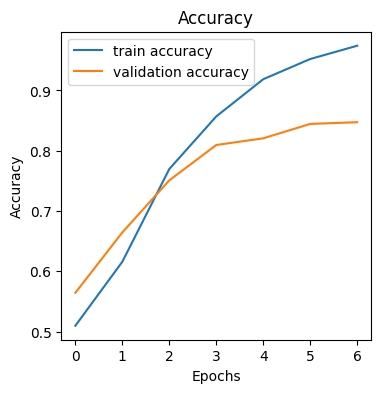

In [ ]:
fig, ax = plt.subplots(figsize=(4, 4))
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show();

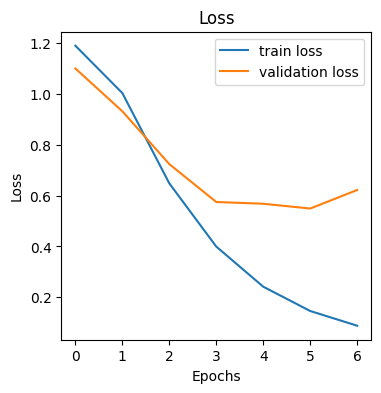

In [ ]:
fig, ax = plt.subplots(figsize=(4, 4)) # Set the figure size to 8x6 inches
ax.set_title('Loss')
ax.plot(history.history['loss'], label='train loss')
ax.plot(history.history['val_loss'], label='validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
ax.legend()
plt.show();

In [ ]:
tst_corpus = test_data["text"]
tst_data= [row.split(',') for row in (train_data['text'].astype(str))]

## text to sequence with the fitted tokenizer
tst_text2seq = tokenizer.texts_to_sequences(tst_data)

## padding sequence
X_test_data = kprocessing.sequence.pad_sequences(tst_text2seq, maxlen=15,
             padding="post", truncating="post")

In [ ]:
#creating submission.csv for LSTM model
seq = tokenizer.texts_to_sequences(test_data['text'])
padded = pad_sequences(seq, maxlen=max_len)
pred = model.predict(padded)
labels = ['non_persuasive','hard_persuasion','general_persuasion','soft_persuasion']


# Create a DataFrame with the tweet, URL, and predicted label
results_df = pd.DataFrame({
    'Tweet': test_data['full_text'],
    'URL': test_data['url'],
    'Predicted Label': [labels[np.argmax(p)] for p in pred]
})

# Export the DataFrame to a CSV file
results_df.to_csv('BiLSTM_word2vec_results.csv', index=False)